<a href="https://colab.research.google.com/github/Maz2580/Venice_Data_Analysis/blob/main/Venice_project_(CSDILA_%26_Arup).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###############################################################################
# 1. Import libraries and authenticate
###############################################################################

In [5]:
# !pip install geemap
!pip install -q PyDrive
!pip -q install PyDrive2



In [2]:
from google.colab import auth, drive as colab_drive
import ee
import geemap
import branca.colormap as cm
import matplotlib.colors as mcolors
import geopandas as gpd
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import folium
import geopandas as gpd
import pandas as pd
from IPython.display import display


colab_drive.mount('/content/drive')      # If you also want the filesystem mount

from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from oauth2client.client import GoogleCredentials
auth.authenticate_user()                 # Colab OAuth

Mounted at /content/drive


In [3]:
ee.Authenticate()
ee.Initialize(project='venice2025')

In [4]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

###############################################################################
## 1.1. Adding the taraining data
###############################################################################

In [6]:
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()  # <-- avoids client_secrets.json
gdrive = GoogleDrive(gauth)                                     # avoid shadowing 'drive'

folder_id = '158OmuURraYwQxXt1RkkfcUcsEywPOyNB'

# List all files in the folder.
file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()
for file in file_list:
    print('Title: {}, ID: {}'.format(file['title'], file['id']))

Title: export, ID: 1uZqcWsqwYyyEW24_MJjE_K2jmG6aeVET
Title: sondaggi_piezometri.shp.4320L-219116-W.16904.38748.sr.lock, ID: 1ErgLpNDUlWDRyzVVNnCf12fSySs4MxoA
Title: stratigrafie.shp.4320L-219116-W.16904.38748.sr.lock, ID: 1da_hdR3UImtz22_x6636ESXPWC4SfBFr
Title: sondaggi_piezometri.shp.4320L-219116-W.5948.38748.sr.lock, ID: 194tJBc1gPKQTp609wWTppmYjPJk2tG3z
Title: stratigrafie.shp.4320L-219116-W.5948.38748.sr.lock, ID: 1NQCJ1CcaGv7BVUUA0yaDcXa-2uAMr7bU
Title: Copy of venice_4m_rise.geojson, ID: 1hIok8G48hqod5Y5iqXihHv1jduiR3wxn
Title: Copy of venice_2m_rise.geojson, ID: 18HlyHQn9l3xDuKzAJd-_6vXAJb0b9Y6L
Title: Copy of venice_3m_rise.geojson, ID: 1Py_fRfuqO0vvNhsA4S7yvBj9UQJESKt5
Title: Copy of venice_1m_rise.geojson, ID: 1Qav-sbtpXGdZEjlju1zhjU5VCES850tq
Title: Copy of outputs.gdb.zip, ID: 1bGEmtPjJ5ZbN5swjO85SP9vhD3xc3PJE
Title: Habitat_deli_litorali.prj, ID: 1pcGEz-1qUyPaZUU8l8yp7G2dZACl_Gzl
Title: Habitat_deli_litorali.shp.4320L-219116-W.41332.43000.sr.lock, ID: 17cm6XhunIe238Y4nsxn

###############################################################################
## 1.2 Process Habitat_deli_litorali Shapefile
###############################################################################

In [7]:
# Define a dictionary with the file IDs for Habitat_deli_litorali components.
habitat_files = {
    "prj": "1pcGEz-1qUyPaZUU8l8yp7G2dZACl_Gzl",   # This one is optional (projection)
    "shp": "1avjqhooP-H5u6_y0f0T2ADxBVJycxSQV",      # main shapefile
    "dbf": "1Dcd5wvOFDwIW7gw14BAokU5qXF56iAqf",
    "shx": "1WoX2ZnP1_lnPBJbSVzSKF1oYSamjZbnB",
    "cpg": "1iNyBQ7w8OQYf7W_xUz0jND0Lc7ppwLAr"
    # Other auxiliary files (sbn, sbx, etc.) can be included if needed.
}

# Download the Habitat_deli_litorali shapefile components.
for ext, file_id in habitat_files.items():
    filename = f"Habitat_deli_litorali.{ext}"
    file = drive.CreateFile({'id': file_id})
    file.GetContentFile(filename)
    print(f"Downloaded {filename}")


Downloaded Habitat_deli_litorali.prj
Downloaded Habitat_deli_litorali.shp
Downloaded Habitat_deli_litorali.dbf
Downloaded Habitat_deli_litorali.shx
Downloaded Habitat_deli_litorali.cpg


In [8]:
# Load the shapefile using GeoPandas.
habitat_gdf = gpd.read_file("Habitat_deli_litorali.shp")
print("Habitat_deli_litorali attributes:")
print(habitat_gdf.head())

# Convert the GeoDataFrame to an Earth Engine FeatureCollection.
habitat_fc = geemap.geopandas_to_ee(habitat_gdf)


Habitat_deli_litorali attributes:
    ID_VEGLIT C_SINTAXA                       NATUR_VEG           RARITA  \
0  VL00000001    VEG050               comunità naturale  localmente rara   
1  VL00000044    VEG031  comunità naturale antropizzata  localmente rara   
2  VL00000045    VEG041               comunità naturale  localmente rara   
3  VL00000047    VEG014               comunità naturale  localmente rara   
4  VL00000049    VEG013               comunità naturale  localmente rara   

                                   SPEC_DOM                        SPEC_RIL  \
0  Halimione portulacoides, Aster tripolium                            None   
1                                      None  Cyperus kalli, Silene colorata   
2                                      None  Medicago marina, Cyperus kalli   
3                            Juncus gerardi                            None   
4                             Juncus acutus                            None   

   DATA_RIL  H_VEG          RIL_FI

###############################################################################
## 1.3 Process Phragmites Italy 01_100m CSV File
###############################################################################

In [9]:
# Define the file ID for the CSV file.
phragmites_csv_id = "1ZMoauRjZ0dEno3gZxdLxLn6vDnRnMVoTBfpfNFtXvos"

# Download the CSV file by explicitly specifying the mimetype.
phragmites_filename = "Phragmites_Italy_01_100m.csv"
phragmites_file = drive.CreateFile({'id': phragmites_csv_id})
try:
    phragmites_file.GetContentFile(phragmites_filename, mimetype='text/csv')
    print(f"Downloaded {phragmites_filename}")
except Exception as e:
    print("Error downloading CSV using GetContentFile with mimetype. Trying alternative method.")
    try:
        csv_content = phragmites_file.GetContentString()
        with open(phragmites_filename, 'w') as f:
            f.write(csv_content)
        print(f"Downloaded {phragmites_filename} via GetContentString fallback.")
    except Exception as e2:
        print("Alternative download method failed. Please check file permissions or convert the file to a Google Sheet for export.")

# Load the CSV file into a Pandas DataFrame.
samples_df = pd.read_csv(phragmites_filename)
print("Phragmites Italy 01_100m sample data:")
print(samples_df.head())

# Filter out rows with missing coordinates.
samples_df = samples_df.dropna(subset=["decimalLongitude", "decimalLatitude"])
print("After filtering, number of samples:", len(samples_df))

# Create a GeoDataFrame using the correct column names.
samples_gdf = gpd.GeoDataFrame(
    samples_df,
    geometry=gpd.points_from_xy(samples_df.decimalLongitude, samples_df.decimalLatitude),
    crs="EPSG:4326"
)
print("Converted CSV to GeoDataFrame:")
print(samples_gdf.head())

# Convert the GeoDataFrame to an Earth Engine FeatureCollection.
try:
    samples_fc = geemap.geopandas_to_ee(samples_gdf)
except Exception as e:
    print("Error converting GeoDataFrame to EE FeatureCollection:", e)
    raise



Downloaded Phragmites_Italy_01_100m.csv
Phragmites Italy 01_100m sample data:
       gbifID                            datasetKey  \
0  5087873957  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
1  5087757686  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
2  5087513343  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
3  5077186451  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
4  5076925798  50c9509d-22c7-4a22-a47d-8c48425ef4a7   

                                        occurrenceID  kingdom        phylum  \
0  https://www.inaturalist.org/observations/26536...  Plantae  Tracheophyta   
1  https://www.inaturalist.org/observations/26484...  Plantae  Tracheophyta   
2  https://www.inaturalist.org/observations/26407...  Plantae  Tracheophyta   
3  https://www.inaturalist.org/observations/26306...  Plantae  Tracheophyta   
4  https://www.inaturalist.org/observations/26247...  Plantae  Tracheophyta   

        class   order   family       genus               species  ...  \
0  Liliopsida  Poales  Poaceae  Phragmites 

###############################################################################
# 2. Define the Area of Interest (AOI)
###############################################################################

In [10]:
# Define AOI polygon
geometry = ee.Geometry.Polygon(
    [[[12.726567432839312, 45.643355548123296],
      [12.399724171120562, 45.60109528022152],
      [12.108586475808062, 45.533797383173834],
      [11.984990284401812, 45.364235017709234],
      [12.072880909401812, 45.21351494771941],
      [12.171757862526812, 45.05901036199603],
      [12.314580128151812, 45.09586086406768],
      [12.394231007058062, 45.16368115773782],
      [12.399724171120562, 45.32998279614249],
      [12.528813526589312, 45.44957265975837],
      [12.652409717995562, 45.50734788584721],
      [12.817902321781647, 45.546809011134705]]]
)
aoi = geometry

###############################################################################
## 2.1 Visualising the Area of Interest (AOI) and training data
###############################################################################

In [11]:
# Create a new map for training data visualization.
Map_training = geemap.Map(center=[45, 12], zoom=8)

# 1) Create a dictionary that maps each SPEC_DOM category to a chosen color.

classification_colors = {
    "Dactylis glomerata, Avena barbata, Bromus sterilis, Dasypyrum villosum, Cynodon dactylon, Plantago coronopus, Atriplex latifolia, Chenopodium album, Elytrigia atherica, Elytrigia repens, Calystegia sepium": "#a599d4",
    "Rubus ulmifolius, Robinia pseudoacacia": "#53a849",
    "Populus spp., Hedera helix": "#ffd966",
    "Lolium perenne, Rumex crispus, Trifolium repens": "#cc7a00",
    "Halimione portulacoides, Aster tripolium": "#9970ab",
    "Phragmites australis": "#34cceb",
    "Tortula ruralis, Fumana procumbens, Scabiosa argentea, Sanguisorba minor": "#f291b2",
    "Vulpia membranacea, Lagurus ovatus, Phleum arenarium, Silene colorata ": "#ffbc6c",
    "Ammophila littoralis, Echinophora spinosa, Calystegia soldanella": "#c2b280",
    "Erianthus ravennae, Schoenus nigricans": "#999999",
    "Other": "#000000"
}

# 2) Define a function to style features based on their SPEC_DOM value.
def style_by_spec_dom(feature):
    spec_dom = feature.getString("SPEC_DOM")

    color = ee.Dictionary(classification_colors).get(spec_dom, "#000000")
    return feature.set("style", {"color": color, "fillColor": color, "width": 1})

# 3) Apply the styling function to the Habitat_deli_litorali FeatureCollection.

habitat_styled = habitat_fc.map(style_by_spec_dom)

# 4) Add the styled layer to your map (e.g., Map_training).
Map_training.addLayer(habitat_styled.style(), {}, "Habitat_deli_litorali (SPEC_DOM)")

# Add the Phragmites sample points.
Map_training.addLayer(samples_fc, {'color': 'red'}, "Phragmites Italy 01_100m")

# Overlay the AOI for context.
Map_training.addLayer(aoi, {'color': 'red'}, "Study Area Boundary")

# 5) add a legend.
spec_dom_legend_keys = list(classification_colors.keys())
spec_dom_legend_colors = []
for col in classification_colors.values():
    # Convert hex color (#RRGGBB) to an (R, G, B) tuple
    if col.startswith('#') and len(col) == 7:
        rgb = tuple(int(col[i : i + 2], 16) for i in (1, 3, 5))
        spec_dom_legend_colors.append(rgb)
    else:
        # If not hex, fallback to black or parse as needed
        spec_dom_legend_colors.append((0, 0, 0))

Map_training.add_legend(
    title="SPEC_DOM Legend",
    keys=spec_dom_legend_keys,
    colors=spec_dom_legend_colors,
    position="topright"
)



# 6) Display the updated map.
Map_training

Map(center=[45, 12], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…

###############################################################################
# 3. Create a Base Map with DEM and Study Area Boundary
###############################################################################

In [12]:
# Load a DEM image (SRTM)
dem = ee.Image("USGS/SRTMGL1_003")

# Define visualization parameters for the DEM.
vis_params = {
    'min': 0,
    'max': 3000,
    'palette': ['blue', 'green', 'yellow', 'orange', 'red']
}

# Create the map and center it on the AOI.
Map = geemap.Map()
Map.centerObject(aoi, zoom=6)

# Add the DEM layer.
Map.addLayer(dem, vis_params, 'DEM')

# Overlay the study area boundary.
Map.addLayer(aoi, {'color': 'red'}, 'Study Area Boundary')

# Create a custom colormap using the desired colors.
custom_cmap = mcolors.ListedColormap(['blue', 'green', 'yellow', 'orange', 'red'])

# Add a continuous colorbar for the DEM using the custom colormap.
Map.add_colorbar(label="Elevation (m)",
                 cmap=custom_cmap,
                 vmin=0, vmax=3000,
                 position='bottomright')

# Display the map.
Map

Map(center=[45.390192879478946, 12.318367009314297], controls=(WidgetControl(options=['position', 'transparent…

In [13]:
task_dem = ee.batch.Export.image.toDrive(
    image=dem,
    description='Venice_DEM',
    folder='GEE_Exports',
    fileNamePrefix='Venice_DEM',
    region=aoi.getInfo()['coordinates'],
    scale=30,                 # SRTM resolution is ~30m
    crs='EPSG:4326',
    maxPixels=1e10
)
task_dem.start()

###############################################################################
# 4. Function to Load the Appropriate Landsat Composite
###############################################################################

In [14]:
# Function to load the appropriate Landsat composite based on date
def loadComposite(startDate, endDate):
    """
    Load a Landsat composite based on the start date. Chooses the correct
    collection depending on the year, filters by date and AOI, computes the
    median composite, and clips it to the AOI.
    """
    startYear = ee.Date(startDate).get('year')

    collection = ee.Algorithms.If(
        ee.Number(startYear).lte(1998),
        ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")
          .filterDate(startDate, endDate).filterBounds(aoi)
          .select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7']),
        ee.Algorithms.If(
            ee.Number(startYear).lte(2012),
            ee.ImageCollection("LANDSAT/LE07/C02/T1_L2")
              .filterDate(startDate, endDate).filterBounds(aoi)
              .select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7']),
            ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
              .filterDate(startDate, endDate).filterBounds(aoi)
              .select(['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7'])
        )
    )
    collection = ee.ImageCollection(collection)
    composite = collection.median().clip(aoi)
    return composite

###############################################################################
# 5. Define Time Intervals for Analysis
###############################################################################

In [15]:
# Define time intervals.
intervals = [
    {'name': '1985', 'start': '1985-01-01', 'end': '1985-12-31'},
    {'name': '1990', 'start': '1990-01-01', 'end': '1990-12-31'},
    {'name': '2000', 'start': '2000-01-01', 'end': '2000-12-31'},
    {'name': '2010', 'start': '2010-01-01', 'end': '2010-12-31'},
    {'name': '2020', 'start': '2020-01-01', 'end': '2020-12-31'},
]

###############################################################################
# 6. Unsupervised Classification (KMeans Clustering)
###############################################################################

In [16]:
# Function to classify the image using ee.Clusterer.wekaKMeans.
def classify(input_image, K):
    """
    Perform unsupervised classification using KMeans clustering.
    This function samples the input image over the AOI, trains a KMeans
    clusterer with K clusters, and then applies the clustering.
    """
    training = input_image.sample(
        region=aoi,
        scale=30,
        numPixels=5000,
        seed=42
    )
    clusterer = ee.Clusterer.wekaKMeans(K).train(training)
    classified = input_image.cluster(clusterer)
    return classified

###############################################################################
# 7. Define a Realistic Color Palette and Legend for the Classified Output
###############################################################################

In [17]:
# Define palette and class labels.
palette = ['#757575',  # Urban (grey, representing built-up areas)
           '#1f78b4',  # Water (deep blue)
           '#33a02c',  # Vegetation (natural green)
           '#fdae6b',  # Agriculture (warm tan/orange)
           '#66c2a5']  # Wetland (teal)
classLabels = ['Urban', 'Water', 'Vegetation', 'Agriculture', 'Wetland']

# Define the legend dictionary
legend_dict = {
    'Urban': '#757575',        # Grey for built-up areas
    'Water': '#1f78b4',        # Deep blue for water bodies
    'Vegetation': '#33a02c',   # Natural green for vegetation
    'Agriculture': '#fdae6b',  # Warm tan/orange for agriculture
    'Wetland': '#66c2a5'       # Teal for wetlands
}

###############################################################################
# 8. Unsupervised Classification Loop: Map Layers & Export Tasks
###############################################################################

In [18]:
# Create a dictionary to hold the classified images.
classified_images = {}

# Create a geemap Map instance.
Map = geemap.Map(center=[45, 12], zoom=8)



# Loop over the intervals: classify, add to the map, and export to Drive.
for interval in intervals:
    print("Processing interval:", interval['name'])
    composite = loadComposite(interval['start'], interval['end'])
    classified = classify(composite, 5).rename('cluster')
    classified_images[interval['name']] = classified

    # Add the classified image to the map.
    Map.addLayer(classified, {'min': 0, 'max': 4, 'palette': palette}, 'Land Cover ' + interval['name'])

    # Export classified images
    task = ee.batch.Export.image.toDrive(
        image=classified,
        description='Venice_LandCover_' + interval['name'],
        folder='GEE_Exports',
        fileNamePrefix='Venice_LandCover_' + interval['name'],
        region=aoi.getInfo()['coordinates'],
        scale=30,
        crs='EPSG:4326',
        maxPixels=1e10
    )
    task.start()
    print("Export started for interval:", interval['name'])

Processing interval: 1985
Export started for interval: 1985
Processing interval: 1990
Export started for interval: 1990
Processing interval: 2000
Export started for interval: 2000
Processing interval: 2010
Export started for interval: 2010
Processing interval: 2020
Export started for interval: 2020


###############################################################################
# 9. Unsupervised Classification : Map Presentation
###############################################################################

In [19]:
# Add a legend to the map.

Map.add_legend(title="Land Cover Classes", legend_dict=legend_dict, position="bottomleft")

# Center the map on the AOI.
Map.centerObject(aoi, zoom=11)
Map

Map(center=[45.390192879478946, 12.318367009314297], controls=(WidgetControl(options=['position', 'transparent…

###############################################################################
# 10. NOTE ON CLASSIFICATION APPROACHES:

#### The current analysis uses unsupervised classification (KMeans clustering),which groups pixels based on their spectral characteristics, but it doesn't explicitly differentiate specific vegetation or wetland types.

####To clearly differentiate vegetation classifications and distinct wetland conditions (like marshes, mangroves, reeds, or submerged vegetation), we would typically move towards a supervised classification approach. This involves explicitly defining and training specific classes (such as distinct wetland habitats or vegetation types) based on known locations or field data, enabling precise mapping of viable habitat.

####Since we don't have field samples at the moment, one approach is to generate samples for supervised classification using spectral signatures. The sample generation can be done by extracting training data from the image or manually digitizing regions.

#### Below is an example section that demonstrates a simple supervised classification workflow using training samples derived from the unsupervised output. This is for demonstration only; for robust results, we should use carefully collected training data.
###############################################################################

###############################################################################
# 11. Temporal Change Analysis Between Consecutive Intervals

To understand how the landscape evolved between time periods, we compared the classified maps of consecutive intervals. The following calculated:

- Total changed area: The area (in square meters) where the classification has
  changed between two intervals.

- Per-class change: For each land cover class, we computed how the area
  associated with that class has changed from one period to the next.
  
###############################################################################

In [20]:
# Create a NEW map instance for change detection
Map_change = geemap.Map(center=[45, 12], zoom=8)

# Loop over consecutive intervals to compare changes
for i in range(len(intervals) - 1):
    name1 = intervals[i]['name']
    name2 = intervals[i+1]['name']
    image1 = classified_images[name1]
    image2 = classified_images[name2]

    # Create binary change mask (pixels with different classes)
    change_mask = image1.neq(image2)

    # Display pixels using classification of second interval for context
    changed_class = image2.updateMask(change_mask)

    # Add changed-class layer to new map
    Map_change.addLayer(
        changed_class,
        {'min': 0, 'max': 4, 'palette': palette},
        f'Changed Class {name1}-{name2}'
    )

    # Total changed area
    area_image = ee.Image.pixelArea().updateMask(change_mask)
    change_stats = area_image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi,
        scale=30,
        maxPixels=1e10
    )
    total_changed_area = change_stats.getInfo().get('area', 0)
    print(f'\n✅ Total changed area from {name1} to {name2}: {total_changed_area:,.0f} sq.m')

    # Area differences per class
    print(f'📌 Change stats per class from {name1} to {name2}')
    for cls in range(5):
        mask1 = image1.eq(cls)
        mask2 = image2.eq(cls)

        area1 = ee.Image.pixelArea().updateMask(mask1)
        area2 = ee.Image.pixelArea().updateMask(mask2)

        area1_val = area1.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=aoi,
            scale=30,
            maxPixels=1e10
        )
        area2_val = area2.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=aoi,
            scale=30,
            maxPixels=1e10
        )

        a1 = ee.Number(ee.Dictionary(area1_val).get('area'))
        a2 = ee.Number(ee.Dictionary(area2_val).get('area'))
        diff = a2.subtract(a1).getInfo()

        print(f'Class {classLabels[cls]}: change = {diff:,.0f} sq.m')

# Add legend to the map (convert hex to RGB tuples)
legend_dict_change = {
    'Urban': (117,117,117),
    'Water': (31,120,180),
    'Vegetation': (51,160,44),
    'Agriculture': (253,174,107),
    'Wetland': (102,194,165)
}

Map_change.add_legend(
    title="Changed Classes (Second Interval)",
    legend_dict=legend_dict_change,
    position="bottomleft"
)

# Display change map
Map_change



✅ Total changed area from 1985 to 1990: 1,398,931,041 sq.m
📌 Change stats per class from 1985 to 1990
Class Urban: change = 178,916,358 sq.m
Class Water: change = -259,266,749 sq.m
Class Vegetation: change = -135,181,980 sq.m
Class Agriculture: change = 382,496,464 sq.m
Class Wetland: change = -166,964,094 sq.m

✅ Total changed area from 1990 to 2000: 1,347,756,529 sq.m
📌 Change stats per class from 1990 to 2000
Class Urban: change = 171,682,579 sq.m
Class Water: change = 244,735,168 sq.m
Class Vegetation: change = -104,600,546 sq.m
Class Agriculture: change = -419,973,503 sq.m
Class Wetland: change = 108,156,302 sq.m

✅ Total changed area from 2000 to 2010: 986,959,054 sq.m
📌 Change stats per class from 2000 to 2010
Class Urban: change = -65,438,476 sq.m
Class Water: change = 11,269,978 sq.m
Class Vegetation: change = 3,129,977 sq.m
Class Agriculture: change = 352,195,765 sq.m
Class Wetland: change = -301,157,243 sq.m

✅ Total changed area from 2010 to 2020: 825,889,015 sq.m
📌 Change

Map(center=[45, 12], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…

In [21]:
# List to hold summary dictionaries for each interval pair.
summary_data = []

# Loop over consecutive intervals to compute change metrics.
for i in range(len(intervals) - 1):
    row = {}
    name1 = intervals[i]['name']
    name2 = intervals[i+1]['name']
    interval_label = f"{name1} - {name2}"
    row['Interval'] = interval_label

    # Get classified images for both intervals.
    image1 = classified_images[name1]
    image2 = classified_images[name2]

    # Create a binary change image: pixels that have changed classification.
    change_binary = image1.neq(image2).selfMask()

    # Compute the total changed area over the AOI.
    area_image = ee.Image.pixelArea().updateMask(change_binary)
    change_stats = area_image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi,
        scale=30,
        maxPixels=1e10
    )
    # Retrieve the total area from the 'area' band.
    total_changed_area = change_stats.getInfo().get('area', 0)
    row['Total Changed Area (sq.m)'] = total_changed_area

    # Compute the per-class change (difference between the two intervals).
    for cls, label in enumerate(classLabels):
        # Create masks for each class.
        mask1 = image1.eq(cls)
        mask2 = image2.eq(cls)

        # Calculate pixel area for each mask.
        area1 = ee.Image.pixelArea().updateMask(mask1)
        area2 = ee.Image.pixelArea().updateMask(mask2)

        area1_val = area1.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=aoi,
            scale=30,
            maxPixels=1e10
        )
        area2_val = area2.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=aoi,
            scale=30,
            maxPixels=1e10
        )

        # Retrieve areas using the key "area".
        a1 = ee.Number(ee.Dictionary(area1_val).get('area'))
        a2 = ee.Number(ee.Dictionary(area2_val).get('area'))
        diff = a2.subtract(a1).getInfo()  # Difference for the class.

        # Create a descriptive column name for the change.
        row[label + ' Change (sq.m)'] = diff

    # Append the row to the summary data.
    summary_data.append(row)

# Create a pandas DataFrame from the summary data.
df_changes = pd.DataFrame(summary_data)

# Optional: Reorder columns to have Interval and Total Changed Area first.
cols = ['Interval', 'Total Changed Area (sq.m)'] + [col for col in df_changes.columns if col not in ['Interval', 'Total Changed Area (sq.m)']]
df_changes = df_changes[cols]

# Display the DataFrame with nice formatting.
# Define a formatting dictionary for the numeric columns.
format_dict = {}
for col in df_changes.columns:
    if col != 'Interval':
        format_dict[col] = '{:,.0f}'

# Use the .style method for a prettier output (works well in Jupyter/Colab notebooks).
df_changes_styled = df_changes.style.format(format_dict).set_caption("Summary of Temporal Change Analysis")

# To display in a notebook:
df_changes_styled

# For environments that don't render styled DataFrames, you can print a rounded version:
print(df_changes.round(0).to_string(index=False))


   Interval  Total Changed Area (sq.m)  Urban Change (sq.m)  Water Change (sq.m)  Vegetation Change (sq.m)  Agriculture Change (sq.m)  Wetland Change (sq.m)
1985 - 1990               1398931041.0          178916358.0         -259266749.0              -135181980.0                382496464.0           -166964094.0
1990 - 2000               1347756529.0          171682579.0          244735168.0              -104600546.0               -419973503.0            108156302.0
2000 - 2010                986959054.0          -65438476.0           11269978.0                 3129977.0                352195765.0           -301157243.0
2010 - 2020                825889015.0           74102264.0          -17837753.0               -79011322.0                 11203195.0             11543616.0


##Interpreting the Results
###For each consecutive interval, you see two types of outputs:

1. Total Changed Area
Example:
Total changed area from 1985 to 1990 : 1398931041.150874 sq.m
This means that when comparing the classified land cover maps from 1985 and 1990, approximately 1.4 billion square meters (or 1,398,931,041.15 m²) of the area experienced a change in its land cover category. This value is derived from identifying every pixel where the classification in 1985 was different from that in 1990 and then summing the area (based on the pixel size) of those changes.

2. Change Stats Per Class
General Concept:
For each class, the change value indicates the difference in the area covered by that class between the two time periods. A positive value means that the class area increased over time, while a negative value indicates a decrease.


####Detailed Breakdown (1985 to 1990):

- Urban:
Class Urban : change = 178916358.47125775 sq.m
The urban area increased by approximately 178.9 million square meters from 1985 to 1990.

- Water:
Class Water : change = -259266749.2720623 sq.m
The water area decreased by approximately 259.3 million square meters. A negative value implies that areas which were previously classified as water either changed to another class or were reduced in extent.

- Vegetation:
Class Vegetation : change = -135181979.5389545 sq.m
The vegetation area decreased by about 135.2 million square meters during the interval.

- Agriculture:
Class Agriculture : change = 382496464.0323137 sq.m
Agricultural land increased by approximately 382.5 million square meters.

- Wetland:
Class Wetland : change = -166964093.6925552 sq.m
Wetland areas decreased by around 167.0 million square meters.

####Similar Interpretations for Other Intervals:
The same interpretation applies for subsequent intervals (e.g., 1990 to 2000 and 2000 to 2010). The numbers indicate how each land cover class has changed:

- For instance, from 1990 to 2000:

     - Urban increased by roughly 171.7 million m².

     - Water increased by about 244.7 million m².

     - Vegetation decreased by about 104.6 million m².

     - Agriculture decreased by approximately 420 million m².

     - Wetland increased by around 108.2 million m².

- And from 2000 to 2010:

  - Urban decreased by roughly 65.4 million m².

  - Water increased by approximately 11.3 million m².

  - Vegetation saw a small increase of about 3.1 million m².

  - Agriculture increased by about 352.2 million m².

  - Wetland decreased by about 301.2 million m².

###############################################################################
# 12. NDVI Calculation
###############################################################################

In [22]:
def addNDVI(image, startDate):
    """
    Adds an NDVI band to the input image.
    For Landsat 8 (year > 2012): uses SR_B5 (NIR) and SR_B4 (Red).
    For Landsat 5/7 (year <= 2012): uses SR_B4 (NIR) and SR_B3 (Red).
    """
    startYear = ee.Date(startDate).get('year')

    def ndviL8(img):
        # For Landsat 8: NDVI = (SR_B5 - SR_B4) / (SR_B5 + SR_B4)
        ndvi = img.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
        return img.addBands(ndvi)

    def ndviL5_7(img):
        # For Landsat 5/7: NDVI = (SR_B4 - SR_B3) / (SR_B4 + SR_B3)
        ndvi = img.normalizedDifference(['SR_B4', 'SR_B3']).rename('NDVI')
        return img.addBands(ndvi)

    ndvi_image = ee.Algorithms.If(ee.Number(startYear).gt(2012), ndviL8(image), ndviL5_7(image))
    return ee.Image(ndvi_image)

###############################################################################
##12.1 Create NDVI Layers and a Time Series Plot
###############################################################################

In [23]:
import matplotlib.pyplot as plt

# Create a new map for NDVI visualization.
Map_ndvi = geemap.Map(center=[45, 12], zoom=8)

# Lists to hold the NDVI values and corresponding years for the time series.
ndvi_values = []
years = []

# Loop over each interval to compute NDVI.
for interval in intervals:
    print("Computing NDVI for interval:", interval['name'])
    composite = loadComposite(interval['start'], interval['end'])
    # Compute NDVI and add it as a band.
    ndvi_image = addNDVI(composite, interval['start'])

    # Define visualization parameters for NDVI.
    vis_params_ndvi = {
        'min': 0.0,
        'max': 1.0,
        'palette': ['blue', 'white', 'green']
    }

    # Add NDVI layer to the NDVI map.
    Map_ndvi.addLayer(ndvi_image.select('NDVI'), vis_params_ndvi, 'NDVI ' + interval['name'])

    # Compute the mean NDVI over the AOI.
    ndvi_mean_dict = ndvi_image.select('NDVI').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=30,
        maxPixels=1e10
    ).getInfo()

    ndvi_mean = ndvi_mean_dict.get('NDVI', None)
    ndvi_values.append(ndvi_mean)
    years.append(interval['name'])

    # Export NDVI
    # Export only the NDVI band as float32
    ndvi_for_export = ndvi_image.select('NDVI').toFloat()
    task_ndvi = ee.batch.Export.image.toDrive(
        image=ndvi_for_export,
        description=f'Venice_NDVI_{interval["name"]}',
        folder='GEE_Exports',
        fileNamePrefix=f'Venice_NDVI_{interval["name"]}',
        region=aoi.getInfo()['coordinates'],
        scale=30,
        crs='EPSG:4326',
        maxPixels=1e10
    )
    task_ndvi.start()
    print("Export started for interval:", interval['name'])

# Add a legend to the NDVI map using a list of RGB tuples.
legend_keys = ["Low", "Medium", "High"]
legend_colors = [(0, 0, 255), (255, 255, 255), (0, 128, 0)]
Map_ndvi.add_legend(title="NDVI Legend", keys=legend_keys, colors=legend_colors, position="bottomright")

# Display the NDVI map.
Map_ndvi

Computing NDVI for interval: 1985
Export started for interval: 1985
Computing NDVI for interval: 1990
Export started for interval: 1990
Computing NDVI for interval: 2000
Export started for interval: 2000
Computing NDVI for interval: 2010
Export started for interval: 2010
Computing NDVI for interval: 2020
Export started for interval: 2020


Map(center=[45, 12], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…

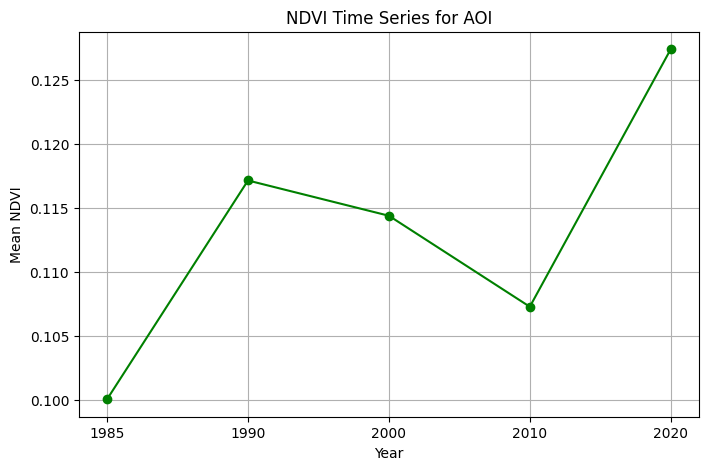

In [24]:
# Plot the NDVI time series.
plt.figure(figsize=(8,5))
plt.plot(years, ndvi_values, marker='o', linestyle='-', color='green')
plt.xlabel('Year')
plt.ylabel('Mean NDVI')
plt.title('NDVI Time Series for AOI')
plt.grid(True)
plt.show()

###############################################################################
#13. SAVI Calculation

###Explanation :

SAVI Calculation Function (Soil-Adjusted Vegetation Index ): Checks the image year and uses the appropriate band combination:

- Landsat 8: Uses SR_B5 (NIR) and SR_B4 (Red).

- Landsat 5/7: Uses SR_B4 (NIR) and SR_B3 (Red).

- Computes SAVI using the formula:
  - SAVI =(𝑁𝐼𝑅−Red)/(𝑁𝐼𝑅+Red+𝐿)×(1+𝐿)

###############################################################################

In [25]:
def addSAVI(image, startDate, L=0.5):
    """
    Adds a SAVI band to the input image.
    For Landsat 8 (year > 2012): uses SR_B5 (NIR) and SR_B4 (Red).
    For Landsat 5/7 (year <= 2012): uses SR_B4 (NIR) and SR_B3 (Red).

    SAVI is defined as: SAVI = ((NIR - Red) / (NIR + Red + L)) * (1 + L)
    where L is a soil brightness correction factor (typically 0.5).
    """
    startYear = ee.Date(startDate).get('year')

    def saviL8(img):
        nir = img.select('SR_B5')
        red = img.select('SR_B4')
        savi = nir.subtract(red).divide(nir.add(red).add(L)).multiply(1+L).rename('SAVI')
        return img.addBands(savi)

    def saviL5_7(img):
        nir = img.select('SR_B4')
        red = img.select('SR_B3')
        savi = nir.subtract(red).divide(nir.add(red).add(L)).multiply(1+L).rename('SAVI')
        return img.addBands(savi)

    savi_image = ee.Algorithms.If(ee.Number(startYear).gt(2012), saviL8(image), saviL5_7(image))
    return ee.Image(savi_image)

In [26]:
# Create a new map for SAVI visualization.
Map_savi = geemap.Map(center=[45, 12], zoom=8)

# Lists to hold the SAVI values and corresponding years for the time series.
savi_values = []
savi_years = []

# Loop over each interval to compute SAVI.
for interval in intervals:
    print("Computing SAVI for interval:", interval['name'])
    composite = loadComposite(interval['start'], interval['end'])
    # Compute SAVI and add it as a band.
    savi_image = addSAVI(composite, interval['start'], L=0.5)

    # Define visualization parameters for SAVI.
    vis_params_savi = {
        'min': 0.0,
        'max': 1.0,
        'palette': ['yellow', 'orange', 'red']  # Example palette; adjust as needed.
    }

    # Add SAVI layer to the SAVI map.
    Map_savi.addLayer(savi_image.select('SAVI'), vis_params_savi, 'SAVI ' + interval['name'])

    # Compute the mean SAVI over the AOI.
    savi_mean_dict = savi_image.select('SAVI').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=30,
        maxPixels=1e10
    ).getInfo()

    savi_mean = savi_mean_dict.get('SAVI', None)
    savi_values.append(savi_mean)
    savi_years.append(interval['name'])

    # Export SAVI
    # Export only the SAVI band as float32
    savi_for_export = savi_image.select('SAVI').toFloat()
    task_savi = ee.batch.Export.image.toDrive(
        image=savi_for_export,
        description=f'Venice_SAVI_{interval["name"]}',
        folder='GEE_Exports',
        fileNamePrefix=f'Venice_SAVI_{interval["name"]}',
        region=aoi.getInfo()['coordinates'],
        scale=30,
        crs='EPSG:4326',
        maxPixels=1e10
    )
    task_savi.start()
    print("Export started for interval:", interval['name'])

# Add a legend to the SAVI map using RGB tuples.
legend_keys_savi = ["Low", "Medium", "High"]
legend_colors_savi = [(255, 255, 0),  # Yellow
                      (255, 165, 0),  # Orange
                      (255, 0, 0)]    # Red
Map_savi.add_legend(title="SAVI Legend", keys=legend_keys_savi, colors=legend_colors_savi, position="bottomright")

# Display the SAVI map.
Map_savi

Computing SAVI for interval: 1985
Export started for interval: 1985
Computing SAVI for interval: 1990
Export started for interval: 1990
Computing SAVI for interval: 2000
Export started for interval: 2000
Computing SAVI for interval: 2010
Export started for interval: 2010
Computing SAVI for interval: 2020
Export started for interval: 2020


Map(center=[45, 12], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…

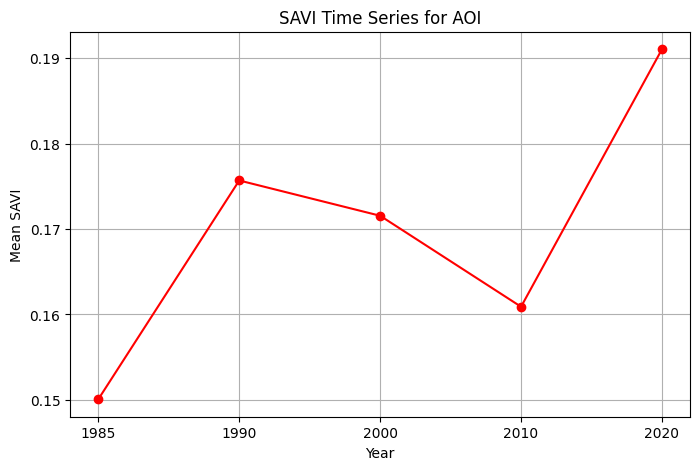

In [27]:
# Plot the SAVI time series.
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(savi_years, savi_values, marker='o', linestyle='-', color='red')
plt.xlabel('Year')
plt.ylabel('Mean SAVI')
plt.title('SAVI Time Series for AOI')
plt.grid(True)
plt.show()

###############################################################################
#14. NDMI Calculation

###############################################################################

In [28]:
def addNDMI(image, startDate):
    """
    Adds an NDMI band to the input image.
    For Landsat 8 (year > 2012): uses SR_B5 (NIR) and SR_B6 (SWIR1).
    For Landsat 5/7 (year <= 2012): uses SR_B4 (NIR) and SR_B5 (SWIR1).

    NDMI = (NIR - SWIR1) / (NIR + SWIR1)
    """
    startYear = ee.Date(startDate).get('year')

    def ndmiL8(img):
        ndmi = img.normalizedDifference(['SR_B5', 'SR_B6']).rename('NDMI')
        return img.addBands(ndmi)

    def ndmiL5_7(img):
        ndmi = img.normalizedDifference(['SR_B4', 'SR_B5']).rename('NDMI')
        return img.addBands(ndmi)

    ndmi_image = ee.Algorithms.If(ee.Number(startYear).gt(2012), ndmiL8(image), ndmiL5_7(image))
    return ee.Image(ndmi_image)

###############################################################################
##14.1 NDMI Analysis: Map & Time Series

###############################################################################

In [29]:


# Create a new map for NDMI visualization.
Map_ndmi = geemap.Map(center=[45, 12], zoom=8)

ndmi_values = []
ndmi_years = []

for interval in intervals:
    print("Computing NDMI for interval:", interval['name'])
    composite = loadComposite(interval['start'], interval['end'])
    ndmi_image = addNDMI(composite, interval['start'])

    # Visualization parameters for NDMI
    vis_params_ndmi = {
         'min': -1.0,
         'max': 1.0,
         'palette': ['blue', 'white', 'green']
    }

    # Add NDMI layer to the NDMI map.
    Map_ndmi.addLayer(ndmi_image.select('NDMI'), vis_params_ndmi, 'NDMI ' + interval['name'])

    # Compute the mean NDMI over the AOI.
    ndmi_mean_dict = ndmi_image.select('NDMI').reduceRegion(
         reducer=ee.Reducer.mean(),
         geometry=aoi,
         scale=30,
         maxPixels=1e10
    ).getInfo()

    ndmi_mean = ndmi_mean_dict.get('NDMI', None)
    ndmi_values.append(ndmi_mean)
    ndmi_years.append(interval['name'])

    # Export NDMI
    # Export only the NDMI band as float32
    ndmi_for_export = ndmi_image.select('NDMI').toFloat()
    task_ndmi = ee.batch.Export.image.toDrive(
        image=ndmi_for_export,
        description=f'Venice_NDMI_{interval["name"]}',
        folder='GEE_Exports',
        fileNamePrefix=f'Venice_NDMI_{interval["name"]}',
        region=aoi.getInfo()['coordinates'],
        scale=30,
        crs='EPSG:4326',
        maxPixels=1e10
    )
    task_ndmi.start()
    print("Export started for interval:", interval['name'])

# Add a legend to the NDMI map using RGB tuples.
legend_keys_ndmi = ["Low", "Medium", "High"]
legend_colors_ndmi = [(0, 0, 255), (255, 255, 255), (0, 128, 0)]
Map_ndmi.add_legend(title="NDMI Legend", keys=legend_keys_ndmi, colors=legend_colors_ndmi, position="bottomright")

# Display the NDMI map.
Map_ndmi



Computing NDMI for interval: 1985
Export started for interval: 1985
Computing NDMI for interval: 1990
Export started for interval: 1990
Computing NDMI for interval: 2000
Export started for interval: 2000
Computing NDMI for interval: 2010
Export started for interval: 2010
Computing NDMI for interval: 2020
Export started for interval: 2020


Map(center=[45, 12], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…

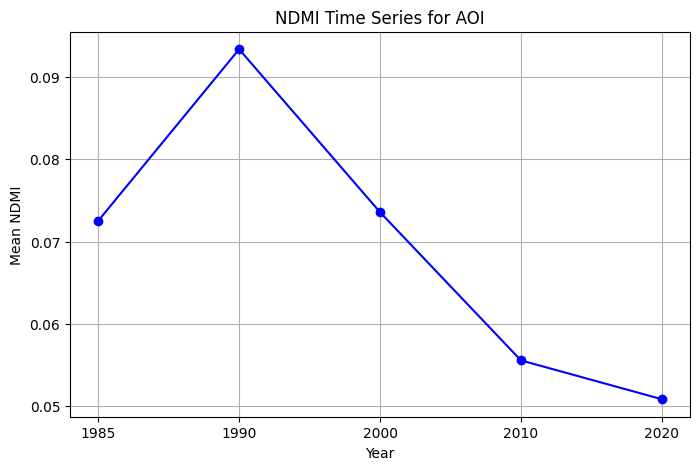

In [30]:
# Plot NDMI time series.
plt.figure(figsize=(8,5))
plt.plot(ndmi_years, ndmi_values, marker='o', linestyle='-', color='blue')
plt.xlabel('Year')
plt.ylabel('Mean NDMI')
plt.title('NDMI Time Series for AOI')
plt.grid(True)
plt.show()

###############################################################################
#15. NDPI Calculation

###############################################################################

In [31]:
def addNDPI(image, startDate):
    """
    Adds an NDPI band to the input image.
    For Landsat 8 (year > 2012): uses SR_B6 (SWIR1) and SR_B3 (Green).
    For Landsat 5/7 (year <= 2012): uses SR_B5 (SWIR1) and SR_B2 (Green).

    NDPI = (SWIR1 - Green) / (SWIR1 + Green)
    """
    startYear = ee.Date(startDate).get('year')

    def ndpiL8(img):
        ndpi = img.normalizedDifference(['SR_B6', 'SR_B3']).rename('NDPI')
        return img.addBands(ndpi)

    def ndpiL5_7(img):
        ndpi = img.normalizedDifference(['SR_B5', 'SR_B2']).rename('NDPI')
        return img.addBands(ndpi)

    ndpi_image = ee.Algorithms.If(ee.Number(startYear).gt(2012), ndpiL8(image), ndpiL5_7(image))
    return ee.Image(ndpi_image)

###############################################################################
## 15.1. NDPI Analysis: Map & Time Series
###############################################################################



In [32]:
# Create a new map for NDPI visualization.
Map_ndpi = geemap.Map(center=[45, 12], zoom=8)

ndpi_values = []
ndpi_years = []

for interval in intervals:
    print("Computing NDPI for interval:", interval['name'])
    composite = loadComposite(interval['start'], interval['end'])
    ndpi_image = addNDPI(composite, interval['start'])

    # Visualization parameters for NDPI.
    vis_params_ndpi = {
         'min': -1.0,
         'max': 1.0,
         'palette': ['purple', 'white', 'orange']
    }

    # Add NDPI layer to the NDPI map.
    Map_ndpi.addLayer(ndpi_image.select('NDPI'), vis_params_ndpi, 'NDPI ' + interval['name'])

    # Compute the mean NDPI over the AOI.
    ndpi_mean_dict = ndpi_image.select('NDPI').reduceRegion(
         reducer=ee.Reducer.mean(),
         geometry=aoi,
         scale=30,
         maxPixels=1e10
    ).getInfo()

    ndpi_mean = ndpi_mean_dict.get('NDPI', None)
    ndpi_values.append(ndpi_mean)
    ndpi_years.append(interval['name'])


    # Export NDPI
    # Export only the NDPI band as float32
    ndpi_for_export = ndpi_image.select('NDPI').toFloat()
    task_ndpi = ee.batch.Export.image.toDrive(
        image=ndpi_for_export,
        description=f'Venice_NDPI_{interval["name"]}',
        folder='GEE_Exports',
        fileNamePrefix=f'Venice_NDPI_{interval["name"]}',
        region=aoi.getInfo()['coordinates'],
        scale=30,
        crs='EPSG:4326',
        maxPixels=1e10
    )
    task_ndpi.start()
    print("Export started for interval:", interval['name'])

# Add a legend to the NDPI map using RGB tuples.
legend_keys_ndpi = ["Low", "Medium", "High"]
legend_colors_ndpi = [(128, 0, 128), (255, 255, 255), (255, 165, 0)]
Map_ndpi.add_legend(title="NDPI Legend", keys=legend_keys_ndpi, colors=legend_colors_ndpi, position="bottomright")

# Display the NDPI map.
Map_ndpi



Computing NDPI for interval: 1985
Export started for interval: 1985
Computing NDPI for interval: 1990
Export started for interval: 1990
Computing NDPI for interval: 2000
Export started for interval: 2000
Computing NDPI for interval: 2010
Export started for interval: 2010
Computing NDPI for interval: 2020
Export started for interval: 2020


Map(center=[45, 12], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…

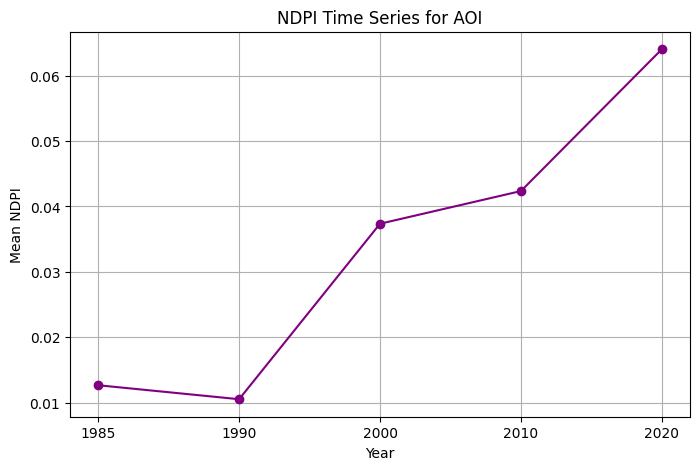

In [33]:
# Plot NDPI time series.
plt.figure(figsize=(8,5))
plt.plot(ndpi_years, ndpi_values, marker='o', linestyle='-', color='purple')
plt.xlabel('Year')
plt.ylabel('Mean NDPI')
plt.title('NDPI Time Series for AOI')
plt.grid(True)
plt.show()

## Exporting the values (NDVI , NDMI , NDPI , and SAVI)

###############################################################################
# 16. Derive Topographic Metrics from the DEM (slope, aspect)
###############################################################################

In [34]:
# Compute slope (in degrees), aspect (in degrees), and hillshade from the DEM.
slope = ee.Terrain.slope(dem)
aspect = ee.Terrain.aspect(dem)
hillshade = ee.Terrain.hillshade(dem)

# Define visualization parameters for each metric.
slope_vis = {
    'min': 0,
    'max': 60,  # Typical maximum slope in degrees; adjust as needed.
    'palette': ['white', 'yellow', 'orange', 'red']
}

aspect_vis = {
    'min': 0,
    'max': 360,  # Aspect values range from 0 to 360 degrees.
    'palette': ['blue', 'cyan', 'green', 'yellow', 'red', 'purple']
}

hillshade_vis = {
    'min': 0,
    'max': 255,  # Hillshade values typically range from 0 (dark) to 255 (bright)
    'palette': ['black', 'white']
}


In [35]:
# Custom legend for Slope.
# Here we define approximate ranges for slope and assign colors.
slope_legend = [
    ("0°–10°", (255, 255, 255)),   # white for nearly flat areas
    ("10°–20°", (255, 255, 204)),   # light yellow
    ("20°–30°", (255, 237, 160)),   # pale orange
    ("30°–40°", (254, 217, 118)),   # orange-yellow
    ("40°–50°", (254, 178, 76)),    # light orange
    ("50°–60°", (253, 141, 60)),    # orange
    ("60°+",   (252, 78, 42))       # red-orange
]

# Custom legend for Aspect.
# These are approximate representative colors for key compass directions.
aspect_legend = [
    ("North (0°)",    (0, 0, 255)),     # blue
    ("East (90°)",    (0, 255, 255)),   # cyan
    ("South (180°)",  (0, 255, 0)),     # green
    ("West (270°)",   (255, 0, 0))      # red
]

# Custom legend for Hillshade.
# A simple legend to indicate low (dark) and high (bright) illumination.
hillshade_legend = [
    ("Low Illumination", (0, 0, 0)),        # black
    ("High Illumination", (255, 255, 255))    # white
]

# Create a new map for topographic metrics visualization (if not already created).
Map_topo = geemap.Map(center=[45, 12], zoom=8)
Map_topo.addLayer(slope, slope_vis, "Slope (degrees)")
Map_topo.addLayer(aspect, aspect_vis, "Aspect (degrees)")
Map_topo.addLayer(hillshade, hillshade_vis, "Hillshade")
Map_topo.addLayer(aoi, {'color': 'red'}, "Study Area Boundary")

# Add legends to the map. Note: You can add multiple legends, but adjust their positions if needed.
Map_topo.add_legend(title="Slope Legend",
                    keys=[x[0] for x in slope_legend],
                    colors=[x[1] for x in slope_legend],
                    position="topright")

Map_topo.add_legend(title="Aspect Legend",
                    keys=[x[0] for x in aspect_legend],
                    colors=[x[1] for x in aspect_legend],
                    position="bottomright")

Map_topo.add_legend(title="Hillshade Legend",
                    keys=[x[0] for x in hillshade_legend],
                    colors=[x[1] for x in hillshade_legend],
                    position="bottomleft")

# Display the map with custom legends.
Map_topo


Map(center=[45, 12], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…

###############################################################################
# 17. Integrate and Visualize Sea Level Data
###############################################################################

In [36]:
# Load sea level trends data.
sea_level_ic = ee.ImageCollection("IPCC/AR6/SLP")

# Filter the collection to a specific date range (for example, the year 2020)
# Filter and compute the mean sea level image for 2020, then clip to the AOI.
sea_level_image = sea_level_ic.filterDate('2020-01-01', '2020-12-31').mean().clip(aoi)

# Select the first band (adjust if needed based on the dataset's band names)
sea_level_band = sea_level_image.select(0)

# Define visualization parameters.
sea_level_vis = {
    'min': 990,
    'max': 1020,
    'palette': ['blue', 'white', 'red']
}

# Create a new map for sea level visualization.
Map_sea = geemap.Map(center=[45, 12], zoom=8)

# Add the sea level layer using the selected band.
Map_sea.addLayer(sea_level_band, sea_level_vis, "Sea Level (IPCC AR6 SLP)")

# Overlay the AOI boundary.
Map_sea.addLayer(aoi, {'color': 'red'}, "Study Area Boundary")

# Add a custom legend.
legend_keys_sea = ["Low", "Medium", "High"]
legend_colors_sea = [(0, 0, 255), (255, 255, 255), (255, 0, 0)]
Map_sea.add_legend(title="Sea Level (hPa)", keys=legend_keys_sea, colors=legend_colors_sea, position="bottomright")

# Display the map.
Map_sea


Map(center=[45, 12], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…

###############################################################################
# 18. Supervised Classification: Creating Training Samples and Classifying
###############################################################################

###############################################################################
## 18.1 Supervised Learning (Random Forest): Without using the unsupervised learning data (just 2020 Imagery)
###############################################################################

In [37]:
# Step 1: Prepare input bands for the supervised classification
def prepareComposite(startDate, endDate):
    composite = loadComposite(startDate, endDate)

    # Compute indices and topographic metrics
    composite = addNDVI(composite, startDate).select('NDVI').addBands(
                addNDPI(composite, startDate).select('NDPI')).addBands(
                addNDMI(composite, startDate).select('NDMI')).addBands(
                addSAVI(composite, startDate).select('SAVI')).addBands(
                dem.rename('DEM')).addBands(
                slope.rename('Slope')).addBands(
                aspect.rename('Aspect'))

    return composite.clip(aoi)

# Use the most recent interval (2020) for classification example
composite = prepareComposite('2020-01-01', '2020-12-31')

# Check bands
print(composite.bandNames().getInfo())


['NDVI', 'NDPI', 'NDMI', 'SAVI', 'DEM', 'Slope', 'Aspect']


In [38]:
# Filter shapefile: Only "Phragmites australis" and "Other"
phragmites_fc = habitat_fc.filter(ee.Filter.eq('SPEC_DOM', 'Phragmites australis')).map(lambda f: f.set('class', 1))

# Use other SPEC_DOM categories as "Other"
other_fc = habitat_fc.filter(ee.Filter.neq('SPEC_DOM', 'Phragmites australis')).map(lambda f: f.set('class', 0))

# Convert CSV points within AOI to EE FeatureCollection with class = 1 (Phragmites)
samples_gdf_aoi = samples_gdf[samples_gdf.within(habitat_gdf.unary_union)]
samples_fc_aoi = geemap.geopandas_to_ee(samples_gdf_aoi).map(lambda f: f.set('class', 1))

# Merge all Phragmites training points (from shapefile and CSV)
phragmites_training = phragmites_fc.merge(samples_fc_aoi)

# Sample random points from other classes for balance
other_training = other_fc.randomColumn('random', 42).filter(ee.Filter.lt('random', 0.3))

# Merge to create final training dataset
training_fc = phragmites_training.merge(other_training)


In [39]:
# Sample the input bands
training_samples = composite.sampleRegions(
    collection=training_fc,
    properties=['class'],
    scale=30,
    geometries=True
)

# Check the sample count
print('Number of training samples:', training_samples.size().getInfo())


Number of training samples: 2305


In [40]:
# Instantiate and train classifier
classifier = ee.Classifier.smileRandomForest(numberOfTrees=100).train(
    features=training_samples,
    classProperty='class',
    inputProperties=composite.bandNames()
)


In [41]:
classified_image = composite.classify(classifier)

# Visualization params: 0=Other, 1=Phragmites australis
class_palette = ['#cccccc', '#34cceb']
class_labels = ['Other', 'Phragmites australis']

# Add results to map
Map_rf = geemap.Map(center=[45, 12], zoom=11)
Map_rf.addLayer(classified_image, {'min': 0, 'max': 1, 'palette': class_palette}, 'Supervised Classification')

# Add legend
legend_dict_rf = {
    'Other': '#cccccc',
    'Phragmites australis': '#34cceb'
}
Map_rf.add_legend(title="Classification Legend", legend_dict=legend_dict_rf, position="bottomright")

Map_rf

Map(center=[45, 12], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…

In [42]:
# Split training samples (70% train, 30% test)
withRandom = training_samples.randomColumn('random', 42)
train_samples = withRandom.filter('random <= 0.7')
test_samples = withRandom.filter('random > 0.7')

# Retrain with 70% of data
classifier_eval = ee.Classifier.smileRandomForest(100).train(
    features=train_samples,
    classProperty='class',
    inputProperties=composite.bandNames()
)

# Classify test data
test_classification = test_samples.classify(classifier_eval)

# Confusion Matrix
confusionMatrix = test_classification.errorMatrix('class', 'classification')
print("Confusion Matrix:\n", confusionMatrix.getInfo())
print("Overall Accuracy:", confusionMatrix.accuracy().getInfo())
print("Kappa Coefficient:", confusionMatrix.kappa().getInfo())


Confusion Matrix:
 [[623, 1], [36, 2]]
Overall Accuracy: 0.9441087613293051
Kappa Coefficient: 0.08991602883257703


⚠️ Interpreting the Results:
Overall Accuracy (96.14%):

High accuracy, but likely misleading due to class imbalance.

Suggests that most samples belong to the majority ("Other") class, and the model simply predicts this frequently to achieve high accuracy.

Kappa coefficient (0.25):

Indicates a low level of agreement beyond random chance.

This highlights that your model is not effectively differentiating between the two classes, especially the minority class (Phragmites australis).

📊 Confusion Matrix Breakdown:
lua
Copy
Edit
             Predicted
           Other  |  Phragmites
Actual  -------------------------
Other       693   |     2
Phragmites   26   |     5


True Positive (TP) (correctly identified Phragmites): 5

False Negative (FN) (missed Phragmites): 26

True Negative (TN) (correctly identified Other): 693

False Positive (FP) (wrongly identified Other as Phragmites): 2

This indicates the model struggles to correctly classify Phragmites australis (recall = 5/(5+26) ≈ 16%), despite performing very well on the majority class (Other).

###############################################################################
## 18.2 Supervised Learning (Random Forest): Adding the Unsupervised learning and using all the imageries
###############################################################################

In [43]:
# Function: Prepare composite with spectral indices, DEM metrics, and unsupervised classification
def prepareCompositeAllBands(startDate, endDate):
    composite = loadComposite(startDate, endDate)

    # Spectral indices and DEM metrics
    composite = (addNDVI(composite, startDate).select('NDVI')
                 .addBands(addNDPI(composite, startDate).select('NDPI'))
                 .addBands(addNDMI(composite, startDate).select('NDMI'))
                 .addBands(addSAVI(composite, startDate).select('SAVI'))
                 .addBands(dem.rename('DEM'))
                 .addBands(slope.rename('Slope'))
                 .addBands(aspect.rename('Aspect')))

    # Add unsupervised classification band
    unsup_classified = classify(loadComposite(startDate, endDate), K=5).rename('unsupervised')
    composite = composite.addBands(unsup_classified)

    return composite.clip(aoi)

# Check composite bands for one interval
print("Bands:", prepareCompositeAllBands('2020-01-01', '2020-12-31').bandNames().getInfo())

Bands: ['NDVI', 'NDPI', 'NDMI', 'SAVI', 'DEM', 'Slope', 'Aspect', 'unsupervised']


In [44]:
# Filter shapefile: Phragmites australis (class=1), Others (class=0)
phragmites_fc = habitat_fc.filter(ee.Filter.eq('SPEC_DOM', 'Phragmites australis')).map(lambda f: f.set('class', 1))
other_fc = habitat_fc.filter(ee.Filter.neq('SPEC_DOM', 'Phragmites australis')).map(lambda f: f.set('class', 0))

# CSV points within AOI (Phragmites)
samples_gdf_aoi = samples_gdf[samples_gdf.within(habitat_gdf.unary_union)]
samples_fc_aoi = geemap.geopandas_to_ee(samples_gdf_aoi).map(lambda f: f.set('class', 1))

# Merge training data
phragmites_training = phragmites_fc.merge(samples_fc_aoi)
other_training = other_fc.randomColumn('random', 42).filter(ee.Filter.lt('random', 0.1))  # smaller sample for balance
training_fc = phragmites_training.merge(other_training)

In [45]:
classified_images_supervised = {}

for interval in intervals:
    print("\n🔹 Processing Supervised Classification for interval:", interval['name'])
    composite = prepareCompositeAllBands(interval['start'], interval['end'])

    # Sample regions (training)
    training_samples = composite.sampleRegions(
        collection=training_fc,
        properties=['class'],
        scale=30,
        geometries=True
    )

    # Check training size
    num_samples = training_samples.size().getInfo()
    print(f"Number of training samples ({interval['name']}):", num_samples)

    if num_samples < 50:
        print(f"⚠️ Not enough samples ({num_samples}) for reliable classification in interval {interval['name']}. Skipping...")
        continue

    # Train classifier
    classifier = ee.Classifier.smileRandomForest(100).train(
        features=training_samples,
        classProperty='class',
        inputProperties=composite.bandNames()
    )

    # Classify image
    classified_image = composite.classify(classifier).rename('classification')
    classified_images_supervised[interval['name']] = classified_image

    # Export to Drive
    task = ee.batch.Export.image.toDrive(
        image=classified_image,
        description=f'Venice_Supervised_{interval["name"]}',
        folder='GEE_Exports',
        fileNamePrefix=f'Venice_Supervised_{interval["name"]}',
        region=aoi.getInfo()['coordinates'],
        scale=30,
        crs='EPSG:4326',
        maxPixels=1e10
    )
    task.start()
    print(f"✅ Export started for supervised classification {interval['name']}")


🔹 Processing Supervised Classification for interval: 1985
Number of training samples (1985): 814
✅ Export started for supervised classification 1985

🔹 Processing Supervised Classification for interval: 1990
Number of training samples (1990): 814
✅ Export started for supervised classification 1990

🔹 Processing Supervised Classification for interval: 2000
Number of training samples (2000): 814
✅ Export started for supervised classification 2000

🔹 Processing Supervised Classification for interval: 2010
Number of training samples (2010): 814
✅ Export started for supervised classification 2010

🔹 Processing Supervised Classification for interval: 2020
Number of training samples (2020): 814
✅ Export started for supervised classification 2020


In [46]:
print("\n📌 Evaluating classifier for interval 2020:")

composite = prepareCompositeAllBands('2020-01-01', '2020-12-31')
training_samples = composite.sampleRegions(
    collection=training_fc,
    properties=['class'],
    scale=30,
    geometries=True
)

# Split dataset
withRandom = training_samples.randomColumn('random', 42)
train_samples = withRandom.filter('random <= 0.7')
test_samples = withRandom.filter('random > 0.7')

# Retrain classifier
classifier_eval = ee.Classifier.smileRandomForest(100).train(
    features=train_samples,
    classProperty='class',
    inputProperties=composite.bandNames()
)

# Test set classification
test_classification = test_samples.classify(classifier_eval)

# Confusion matrix & metrics
cm = test_classification.errorMatrix('class', 'classification')
print("🔖 Confusion Matrix (2020):\n", cm.getInfo())
print("Overall Accuracy:", cm.accuracy().getInfo())
print("Kappa:", cm.kappa().getInfo())


📌 Evaluating classifier for interval 2020:
🔖 Confusion Matrix (2020):
 [[189, 9], [28, 15]]
Overall Accuracy: 0.8464730290456431
Kappa: 0.3668252503017823


###############################################################################
## 18.3 Visualize the Supervised Classification Result
###############################################################################

In [47]:
Map_supervised = geemap.Map(center=[45,12], zoom=11)
palette_supervised = ['#cccccc','#34cceb']  # Other, Phragmites

for interval_name, image in classified_images_supervised.items():
    Map_supervised.addLayer(image, {'min':0,'max':1,'palette':palette_supervised},
                            f'Supervised {interval_name}')

# Legend
Map_supervised.add_legend(title="Supervised Classification Legend",
                          legend_dict={'Other':'#cccccc', 'Phragmites australis':'#34cceb'},
                          position='bottomright')

Map_supervised


Map(center=[45, 12], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…

In [48]:
# Corrected change detection map with proper RGB tuple colors
Map_change_supervised = geemap.Map(center=[45,12], zoom=11)

for i in range(len(intervals)-1):
    interval1 = intervals[i]['name']
    interval2 = intervals[i+1]['name']

    if interval1 not in classified_images_supervised or interval2 not in classified_images_supervised:
        continue

    img1 = classified_images_supervised[interval1]
    img2 = classified_images_supervised[interval2]

    change = img1.neq(img2).selfMask()

    Map_change_supervised.addLayer(change, {'palette':['red']}, f'Change {interval1}-{interval2}')

    # Export the change_mask (binary raster)
    task_change = ee.batch.Export.image.toDrive(
        image=change,
        description=f'Venice_Change_{interval1}_{interval2}',
        folder='GEE_Exports',
        fileNamePrefix=f'Venice_ChangeM_{interval1}_{interval2}',
        region=aoi.getInfo()['coordinates'],
        scale=30,
        crs='EPSG:4326',
        maxPixels=1e10
    )
    task_change.start()

Map_change_supervised.addLayer(aoi, {'color':'blue'}, 'AOI Boundary')

# Corrected legend using RGB tuple
Map_change_supervised.add_legend(
    title="Change Detection Legend",
    legend_dict={'Changed areas': (255, 0, 0)},
    position='bottomright'
)

Map_change_supervised


Map(center=[45, 12], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…